In [1]:
# imports
from __future__ import division, print_function
%matplotlib inline

import os, sys, types
import pathlib
from importlib import reload
import numpy as np
from scipy.linalg import expm
import qinfer as qi
import matplotlib.pyplot as plt
import functools

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [2]:
# For local package imports
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [3]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

In [4]:
import bayesianhl

# 1. Check ActionSpace

In [5]:
from bayesianhl.action_space import ActionSpace

In [6]:
# Define quantum system model
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

In [7]:
# Define query space
moset = [0,1,2]
prepset = [0,1]
time_stamps = np.linspace(1e-7, 6e-7, 81)
tset = time_stamps/xi_t

query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

In [8]:
A_cr = ActionSpace(moset, prepset, tset, xi_t, xi_J)

# 2. Run a PL job on simulator

In [9]:
reload_package(bayesianhl)

In [10]:
from bayesianhl.bayesian_learner import ExperimentRunner

In [11]:
# Set true values
J_truth = np.array([[-4568258.88132824, -1465045.02848701,  -290468.97835928,
                    6499545.9801579,  1390900.08768167,   413722.74870734]])

In [12]:
# This is what we will actually run with -- non-dimensional parameters 
J_truth_nd = J_truth/xi_J

In [13]:
J_truth_nd

array([[-4.56825888, -1.46504503, -0.29046898,  6.49954598,  1.39090009,
         0.41372275]])

In [14]:
# Set up experiment runner

# Experiment parameters
N_0 = 5*A_cr.N_actions
N_batch = 2*A_cr.N_actions
max_iter = 5

# estimator relevant parameters
n_particles = 5000

learner_expt = ExperimentRunner(J_truth_nd, query_space, xi_J, xi_t, FLAG_control_noise=True,
                                N_0=N_0, N_batch=N_batch, max_iter=max_iter, n_particles=n_particles)

Running with control noise model on!


In [15]:
i_run = 8
np.random.seed(10 * (i_run + 2))

results_PL = learner_expt.PL_runner(log_file='PL_sim_cr_test.txt')

/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/bayesian_learner.py:146: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  experiment_temp = np.array([(m, u, t, n_shots)], dtype=self.sys_model.expparams_dtype)
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Passive Learning -- Uniform query distribution


In [16]:
results_PL.keys()

dict_keys(['loss', 'mse', 'J_hat', 'J_truth_nd', 'xi_J', 'N_p', 'q', 'n_shots', 'data', 'samples', 'A_cr'])

In [17]:
# Loss from results
loss = results_PL['loss']

In [18]:
# Compute loss in another way through SystemModel
J_hat = results_PL['J_hat'][-1]
xi_J = results_PL['xi_J']
X_p = results_PL['data']
Y_p = results_PL['samples']

In [19]:
loss

[0.4954789479410335,
 0.49235722472971816,
 0.49391009581440987,
 0.4941448368097895,
 0.49805096875681915,
 0.4966230785165295]

In [24]:
loss_est = bayesianhl.utilities_quantum_device.log_likelihood_loss_system_model(J_hat/xi_J, X_p, Y_p, 
                                                                                xi_J=xi_J, 
                                                                                FLAG_control_noise=True)

In [25]:
loss_est

0.4966230785165313

In [26]:
loss_est2 = bayesianhl.utilities_quantum_device.log_likelihood_loss(J_hat/xi_J, X_p, Y_p, 
                                                                    xi_J=xi_J,
                                                                    FLAG_control_noise=True)

In [27]:
loss_est2

0.4966230785165295

In [28]:
A_cr = results_PL['A_cr']

# 3. ActiveSMC (SMC + HAL-FI/HAL-FIR) on simulator

In [12]:
reload_package(bayesianhl)

In [13]:
from bayesianhl import design_experiment, quantum_device_models

In [14]:
from bayesianhl.utils.utilities_plotting import visualize_query_distrn

## 3.0 HAL-FI distribution from a job

In [13]:
# Setup the ActiveLearner
policy_type = 'FI'
FLAG_normalization = True
FLAG_noise = True
growth_time_stamps = None
#FLAG_constraints = True

#query_constraints_ref = {'N_shots': 512}
#FLAG_lower_limits = False

HAL_FI_J = design_experiment.ActiveLearner(policy_type=policy_type,
                                           FLAG_normalization=FLAG_normalization,
                                           FLAG_noise=FLAG_noise,
                                           type_param='J')

In [14]:
# Create a quantum system model from the PL data collected before 
J_hat = results_PL['J_hat'][-1]
xi_J = results_PL['xi_J']
A_cr = results_PL['A_cr']

qs_noise = {'readout': [0., 0.],
            'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                                   FLAG_ibmq_boel=True),
            'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                        FLAG_ibmq_boel=True)}

qs_model = quantum_device_models.SystemModel(J_hat, xi_J, noise=qs_noise,
                                             FLAG_readout_noise=False,
                                             FLAG_control_noise=True)

# Define the uniform distribution
p_U = (1/A_cr.N_actions)*np.ones(A_cr.N_actions)

# Run it on the dataset from above
q_dist = HAL_FI_J.optimal_query_distribution(A_cr, qs_model, p_ref=p_U, FLAG_verbose_solver=False)

NameError: name 'results_PL' is not defined

/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/utilities_plotting.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig_axis.set_yticklabels(ylabels_plot)


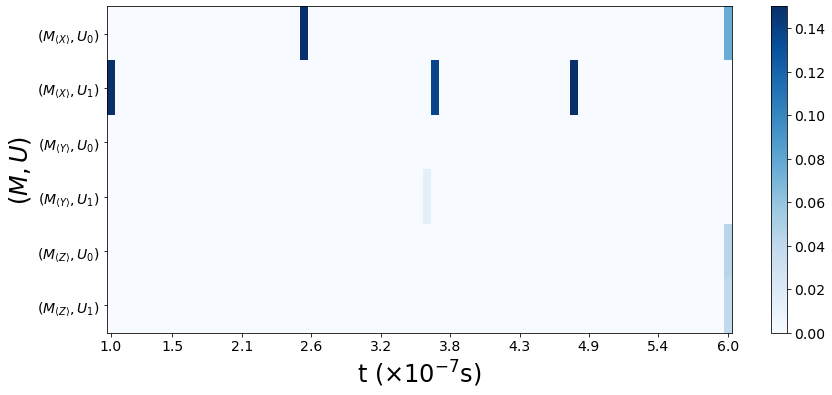

In [59]:
visualize_query_distrn(A_cr, q_dist, cmax=0.15, FLAG_indicate_query_space=True)

### Let us compare against the true distribution

In [65]:
# Create a quantum system model from the PL data collected before 
xi_J = results_PL['xi_J']
J_truth = xi_J*results_PL['J_truth_nd'][0]
A_cr = results_PL['A_cr']

print(J_truth)

qs_noise = {'readout': [0., 0.],
            'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                                   FLAG_ibmq_boel=True),
            'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                        FLAG_ibmq_boel=True)}

qs_model_true = quantum_device_models.SystemModel(J_truth, xi_J, noise=qs_noise,
                                                  FLAG_readout_noise=False,
                                                  FLAG_control_noise=True)

# Define the uniform distribution
p_U = (1/A_cr.N_actions)*np.ones(A_cr.N_actions)

# Run it on the dataset from above
q_dist = HAL_FI_J.optimal_query_distribution(A_cr, qs_model_true, p_ref=p_U, FLAG_verbose_solver=False)

[-4568258.88132824 -1465045.02848701  -290468.97835928  6499545.9801579
  1390900.08768167   413722.74870734]


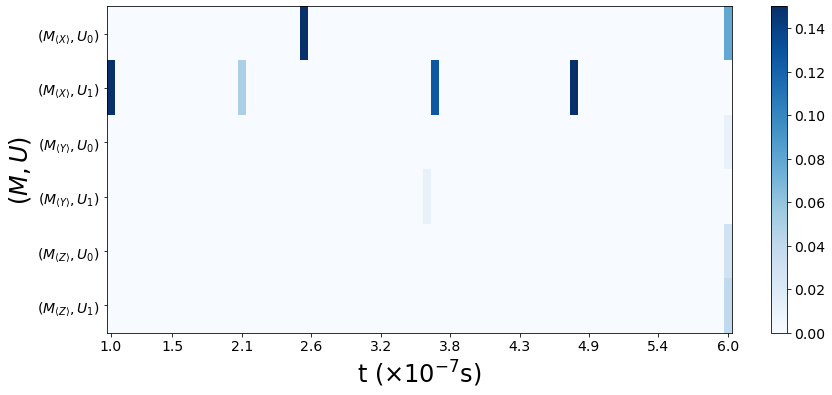

In [66]:
visualize_query_distrn(A_cr, q_dist, cmax=0.15, FLAG_indicate_query_space=True)

### What does the HAL-FIR distribution look like?

In [72]:
# Setup the ActiveLearner
policy_type = 'FIR'
FLAG_normalization = True
FLAG_noise = True
growth_time_stamps = None
# FLAG_constraints = True

# query_constraints_ref = {'N_shots': 512}
# FLAG_lower_limits = False

HAL_FIR_J = design_experiment.ActiveLearner(policy_type=policy_type,
                                            FLAG_normalization=FLAG_normalization,
                                            FLAG_noise=FLAG_noise,
                                            type_param='J')

Considering estimate

In [73]:
# Run it considering the estimate
q_dist = HAL_FIR_J.optimal_query_distribution(A_cr, qs_model, p_ref=p_U, FLAG_verbose_solver=False)

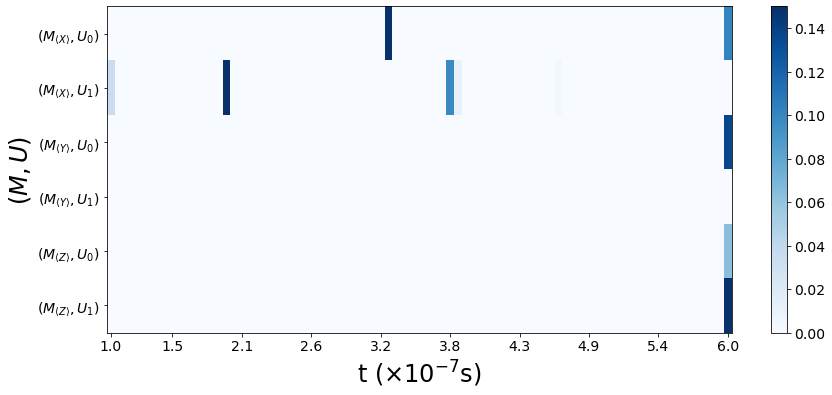

In [74]:
visualize_query_distrn(A_cr, q_dist, cmax=0.15, FLAG_indicate_query_space=True)

Considering truth

In [77]:
# Run it considering the truth
q_dist = HAL_FIR_J.optimal_query_distribution(A_cr, qs_model_true, p_ref=p_U, FLAG_verbose_solver=False)

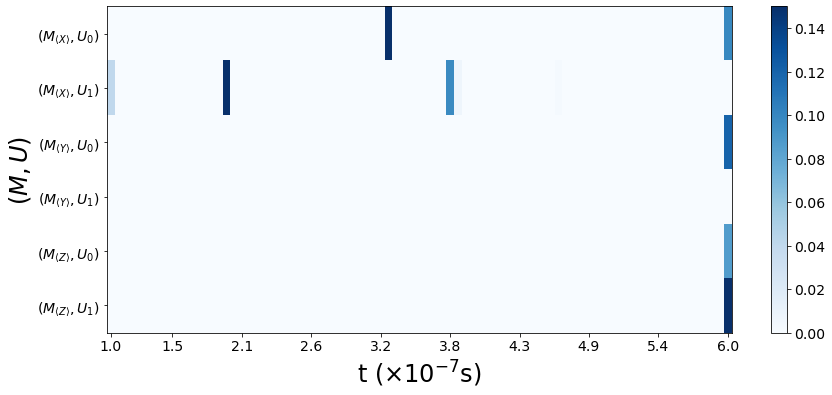

In [78]:
visualize_query_distrn(A_cr, q_dist, cmax=0.15, FLAG_indicate_query_space=True)

## 3.1 HAL-FI job

In [15]:
reload_package(bayesianhl)

In [16]:
from bayesianhl.active_bayesian_learner import ActiveExperimentRunner

In [17]:
# Set true values
J_truth = np.array([[-4568258.88132824, -1465045.02848701,  -290468.97835928,
                    6499545.9801579,  1390900.08768167,   413722.74870734]])

In [18]:
# This is what we will actually run with -- non-dimensional parameters 
J_truth_nd = J_truth/xi_J

In [19]:
# Define the active learner
policy_type = 'FI'
FLAG_normalization = True
FLAG_noise = True
growth_time_stamps = None
FLAG_constraints = True

query_constraints_ref = {'N_shots': 512}
FLAG_lower_limits = False

HAL_FI_J = design_experiment.ActiveLearner(policy_type=policy_type,
                                           FLAG_normalization=FLAG_normalization,
                                           FLAG_constraints=FLAG_constraints,
                                           query_constraints=query_constraints_ref,
                                           FLAG_noise=FLAG_noise,
                                           type_param='J')

In [21]:
# Set up experiment runner

# Experiment parameters
N_0 = 5*A_cr.N_actions
N_batch = 2*A_cr.N_actions
max_iter = 5

# estimator relevant parameters
n_particles = 5000

FLAG_query_constraints = True
query_constraints_info = {'query_constraints_ref': None, 'query_optimization_type': 'batch'}

active_learner_expt = ActiveExperimentRunner(J_truth_nd, query_space, xi_J, xi_t, HAL_FI_J,
                                             FLAG_query_constraints=FLAG_query_constraints, 
                                             query_constraints_info=query_constraints_info,
                                             FLAG_control_noise=True,
                                             N_0=N_0, N_batch=N_batch, max_iter=max_iter, 
                                             n_particles=n_particles)

Running with control noise model on!


In [22]:
i_run = 8
np.random.seed(10 * (i_run + 2))

results_AL = active_learner_expt.AL_runner(log_file='AL_sim_cr_test.txt')

/home/gridsan/arkopal/Research/QinferHL/qinfer-hl/bayesianhl/active_bayesian_learner.py:211: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  experiment_temp = np.array([(m, u, t, n_shots)], dtype=self.sys_model.expparams_dtype)
/home/gridsan/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Active Learning -- HAL-FI/HAL-FIR query distribution
Solving with query constraints
Upper limits being set
Solving with query constraints
Upper limits being set
Solving with query constraints
Upper limits being set
Solving with query constraints
Upper limits being set
Solving with query constraints
Upper limits being set


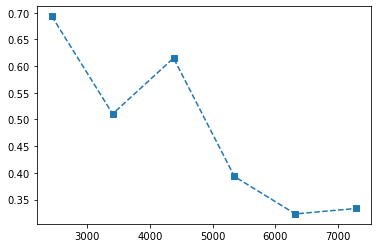

In [23]:
plt.plot(results_AL['N_p'], np.sqrt(results_AL['mse']), '--s', label='SMC + AL')

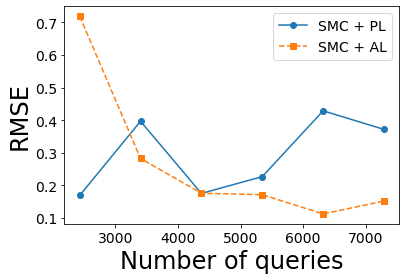

In [169]:
# Compare the above result against the earlier PL result
plt.plot(results_PL['N_p'], np.sqrt(results_PL['mse']), '-o', label='SMC + PL')
plt.plot(results_AL['N_p'], np.sqrt(results_AL['mse']), '--s', label='SMC + AL')
plt.xlabel('Number of queries')
plt.ylabel('RMSE')
plt.legend()

/Users/arkopal/Dropbox (Personal)/Research/Focus/HAL_FI/Code/qinfer-hl/bayesianhl/utilities_plotting.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig_axis.set_yticklabels(ylabels_plot)


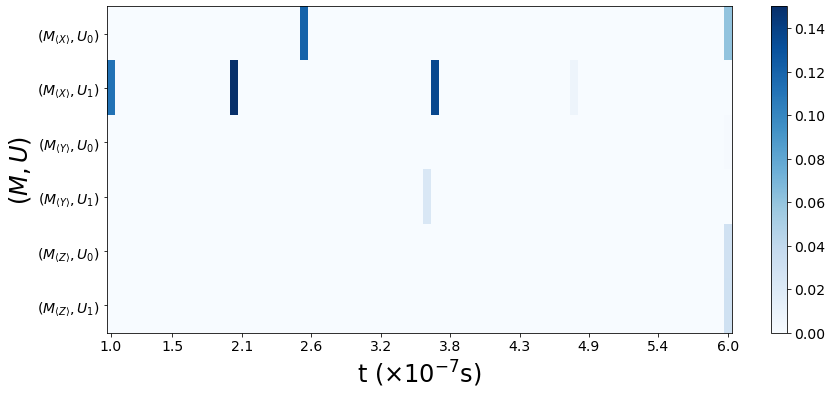

In [170]:
q_dist = results_AL['q'][-1]
A_cr = results_AL['A_cr']

visualize_query_distrn(A_cr, q_dist, cmax=0.15, FLAG_indicate_query_space=True)

Checking if ActionSpace methods are working correctly!

In [171]:
A_cr.nonempty_actions()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [172]:
A_cr.filtered_actions()

[(0, 0, 1.0),
 (0, 1, 1.0),
 (1, 0, 1.0),
 (1, 1, 1.0),
 (2, 0, 1.0),
 (2, 1, 1.0),
 (0, 0, 1.0625),
 (0, 1, 1.0625),
 (1, 0, 1.0625),
 (1, 1, 1.0625),
 (2, 0, 1.0625),
 (2, 1, 1.0625),
 (0, 0, 1.125),
 (0, 1, 1.125),
 (1, 0, 1.125),
 (1, 1, 1.125),
 (2, 0, 1.125),
 (2, 1, 1.125),
 (0, 0, 1.1875),
 (0, 1, 1.1875),
 (1, 0, 1.1875),
 (1, 1, 1.1875),
 (2, 0, 1.1875),
 (2, 1, 1.1875),
 (0, 0, 1.25),
 (0, 1, 1.25),
 (1, 0, 1.25),
 (1, 1, 1.25),
 (2, 0, 1.25),
 (2, 1, 1.25),
 (0, 0, 1.3125),
 (0, 1, 1.3125),
 (1, 0, 1.3125),
 (1, 1, 1.3125),
 (2, 0, 1.3125),
 (2, 1, 1.3125),
 (0, 0, 1.3750000000000002),
 (0, 1, 1.3750000000000002),
 (1, 0, 1.3750000000000002),
 (1, 1, 1.3750000000000002),
 (2, 0, 1.3750000000000002),
 (2, 1, 1.3750000000000002),
 (0, 0, 1.4375),
 (0, 1, 1.4375),
 (1, 0, 1.4375),
 (1, 1, 1.4375),
 (2, 0, 1.4375),
 (2, 1, 1.4375),
 (0, 0, 1.5),
 (0, 1, 1.5),
 (1, 0, 1.5),
 (1, 1, 1.5),
 (2, 0, 1.5),
 (2, 1, 1.5),
 (0, 0, 1.5625),
 (0, 1, 1.5625),
 (1, 0, 1.5625),
 (1, 1, 1.562